# 傾向スコア分析の実装

----

ライブラリのインポート

causallibについては(https://github.com/BiomedSciAI/causallib)(https://causallib.readthedocs.io/_/downloads/en/latest/pdf/)  
sklearnについては(https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)  
を参照

In [1]:
import pandas as pd
import numpy as np

from causallib.datasets import load_nhefs
from causallib.estimation import IPW, PropensityMatching,StratifiedStandardization
from causallib.evaluation import evaluate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

ライブラリに入ってるデータセットを使う

In [2]:
data = load_nhefs()
data

{'X':       age  race  sex  smokeintensity  smokeyrs   wt71  active_1  active_2  \
 0      42     1    0              30        29  79.04     False     False   
 1      36     0    0              20        24  58.63     False     False   
 2      56     1    1              20        26  56.81     False     False   
 3      68     1    0               3        53  59.42      True     False   
 4      40     0    0              20        19  87.09      True     False   
 ...   ...   ...  ...             ...       ...    ...       ...       ...   
 1623   47     0    1              20        31  84.94     False     False   
 1624   45     0    0              40        29  63.05     False     False   
 1625   47     0    1              20        31  57.72     False     False   
 1627   68     0    0              15        46  52.39      True     False   
 1628   29     0    0              30        14  90.83      True     False   
 
       education_2  education_3  education_4  education_5

In [3]:
X = data.X #共変量
T = data.a #処置変数
y = data.y #結果変数

df = X.join(T).join(y)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1566 entries, 0 to 1628
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1566 non-null   int64  
 1   race              1566 non-null   int64  
 2   sex               1566 non-null   int64  
 3   smokeintensity    1566 non-null   int64  
 4   smokeyrs          1566 non-null   int64  
 5   wt71              1566 non-null   float64
 6   active_1          1566 non-null   bool   
 7   active_2          1566 non-null   bool   
 8   education_2       1566 non-null   bool   
 9   education_3       1566 non-null   bool   
 10  education_4       1566 non-null   bool   
 11  education_5       1566 non-null   bool   
 12  exercise_1        1566 non-null   bool   
 13  exercise_2        1566 non-null   bool   
 14  age^2             1566 non-null   int64  
 15  wt71^2            1566 non-null   float64
 16  smokeintensity^2  1566 non-null   int64  
 17  

None

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,qsmk,wt82_71
0,42,1,0,30,29,79.04,False,False,False,False,False,False,False,True,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,False,False,True,False,False,False,False,False,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,False,False,True,False,False,False,False,True,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,True,False,False,False,False,False,False,True,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,True,False,True,False,False,False,True,False,1600,7584.6681,400,361,0,4.989251


In [4]:
cols = X.columns.tolist()
treat = T.name
target = y.name

#Bool値を0 1に変換
X = X.astype(int)
df = df.astype(int)
df.reset_index(drop=True, inplace=True)
X = df[cols]
T = df[treat]
y = df[target]

### 傾向スコアの計算

手計算

In [5]:
propensity_score = LogisticRegression(
    solver="liblinear",
    class_weight = "balanced"
).fit(X,T)

print(f"accuracy: {propensity_score.score(X,T)}")
ps_prob = propensity_score.predict_proba(X)[:,1] #T=1になる確率を保持

df['ps'] = ps_prob

accuracy: 0.6219667943805874


In [6]:
'''
import statsmodels.api as sm
#X = sm.add_constant(X)
# 傾向スコアを算出
model = sm.Logit(T, X)
result = model.fit()
result.predict(X)

df["傾向スコア"] = result.predict(X)
df.head()
'''

'\nimport statsmodels.api as sm\n#X = sm.add_constant(X)\n# 傾向スコアを算出\nmodel = sm.Logit(T, X)\nresult = model.fit()\nresult.predict(X)\n\ndf["傾向スコア"] = result.predict(X)\ndf.head()\n'

Causallibでは算出した傾向スコアではなく、算出するためのモデルを引き渡す(ただし、sklearnのものに限定)

In [7]:
#引き渡すモデルを定義
ps = LogisticRegression(
    solver="liblinear",
    class_weight = "balanced"
)

### マッチング

---

In [8]:
pm = PropensityMatching(learner=ps)
pm.fit(X,T,y)

PropensityMatching(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.4/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, caliper=None, covariance_conditioner=EmpiricalCovariance(), estimate_observed_outcome=False, knn_backend=sklearn, matching_mode=both, metric=mahalanobis, n_neighbors=1, propensity_transform=PropensityTransformer(learner=LogisticRegression(class_weight='balanced',
                                                 solver='liblinear')), with_replacement=True,
                   learner=LogisticRegression(class_weight='balanced', solver='liblinear'))

In [9]:
# 因果効果の推定（ATE）
outcomes = pm.estimate_population_outcome(X, T) #処置群の平均値は[1]に、対照群の平均値は[0]に格納されてる
ate_match = pm.estimate_effect(outcomes[1], outcomes[0]) #ATEは["diff"]に格納されてる

print(f"処置群の平均値: {outcomes[0]}")
print(f"対照群の平均値: {outcomes[1]}")
print(f"ATE: {ate_match['diff']}")

処置群の平均値: 1.586845466155811
対照群の平均値: 4.666666666666667
ATE: 3.079821200510856


### IPW

---

#### 手計算  

どうやらATEの計算は２通りあるらしく、ライブラリの方は後者を採用している。  
$$ATE = \frac{1}{N} \sum_{i=1}^N \frac{T_i}{e(X_i)}Y_i - \frac{1}{N} \sum_{i=1}^N \frac{1 - T_i}{1 - e(X_i)}Y_i \tag{1}$$
$$ATE = \frac{\sum_{i=1}^N \frac{T_i}{e(X_i)}Y_i}{\sum_{i=1}^N \frac{T_i}{e(X_i)}} - \frac{\sum_{i=1}^N \frac{1 - T_i}{1 - e(X_i)}Y_i}{\sum_{i=1}^N \frac{1 - T_i}{1 - e(X_i)}} \tag{2}$$

とりあえず（１）を計算  

In [10]:
#(1)
n = len(df)
df['ipw'] = 1 / np.where(df['qsmk'] == 1, df['ps'], 1 - df['ps']) 
df['y_ipw'] = df['wt82_71'] * df['ipw']
ate_ipw = df[df['qsmk']==1]['y_ipw'].sum() / n - df[df['qsmk']==0]['y_ipw'].sum() / n

ate_ipw


0.27544256970991476

全然違う  

（２）を計算  

In [11]:
#(2)
ate_ipw = df[df['qsmk']==1]['y_ipw'].sum() / df[df['qsmk']==1]['ipw'].sum() - df[df['qsmk']==0]['y_ipw'].sum() / df[df['qsmk']==0]['ipw'].sum()

ate_ipw

3.2840103327980845

次のライブラリと同様の値となっている

#### ライブラリを使った計算

In [12]:
ipw = IPW(learner = ps)
ipw.fit(X, T, y)

# ATEの計算
outcomes = ipw.estimate_population_outcome(X, T, y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

#結果の出力
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
print(f"Average outcome of treated: {outcomes[1]:.3f}")
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.441
Average outcome of treated: 4.725
Average Treatment Effect: 3.284


### 評価

In [13]:
results = evaluate(ipw, X, T, y)
results.evaluated_metrics.prediction_scores

,accuracy,precision,recall,f1,roc_auc,avg_precision,hinge,matthews,0_1,brier,confusion_matrix,roc_curve,pr_curve
0,0.621967,0.356601,0.583127,0.442561,0.663698,0.410757,1.20029,0.193531,0.378033,0.228622,"[[739, 424], [168, 235]]","([0.0, 0.0, 0.0, 0.0025795356835769563, 0.0025...","([0.25734355044699875, 0.25750798722044727, 0...."


<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

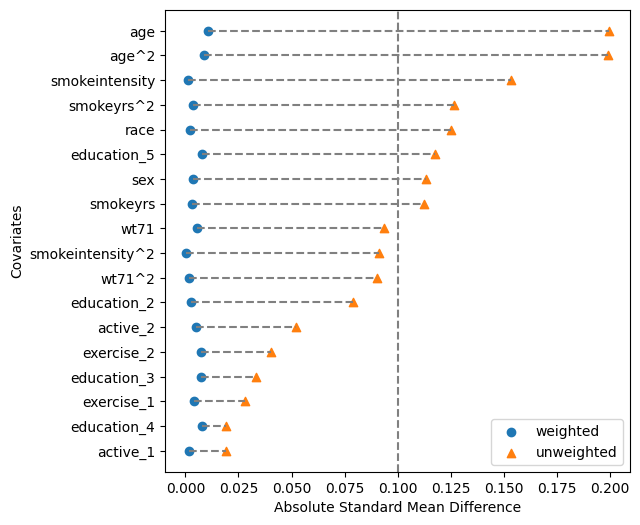

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(6,6))
results.plot_covariate_balance(kind="love", ax=ax, thresh=0.1)

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

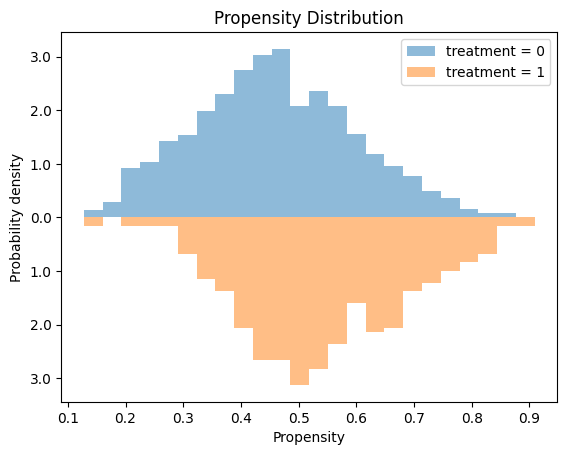

In [15]:
results.plot_weight_distribution()